# Minprj : exp13_ DC_GAN
> date : 16 Nov 2021<br>
> author : bae hueng myoung
    

## work(0) : init

In [ ]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.7.0


In [ ]:
! pip list | grep imageio&&PIL

imageio                       2.4.1
/bin/bash: PIL: command not found


In [ ]:
cifar10 = tf.keras.datasets.cifar10
(train_x, _),(test_x, _) = cifar10.load_data()
train_x.shape

(50000, 32, 32, 3)

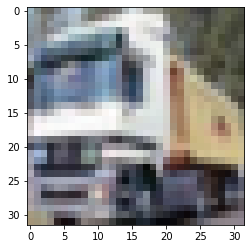

In [ ]:
plt.imshow(train_x[1])

## work(1) : normalization (from -1 to +1 )

In [ ]:
datamax = train_x.max()
half = datamax/2
half

127.5

In [ ]:
train_x = (train_x - half)/half
print('normal max : ', train_x.max())
print('normal min : ', train_x.min())

normal max :  1.0
normal min :  -1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

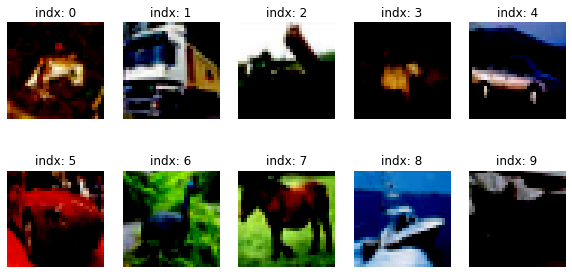

In [ ]:
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(train_x[i])
    plt.title(f'indx: {i}')
    plt.axis('off')
plt.show()

## work(2) : config of batch

In [ ]:
BUFFER_SIZE = 50000     # input data number is 50000
BATCH_SIZE = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE)
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.ShuffleDataset

## work(3) : design of generator

In [ ]:
# using keras sequential API

def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256*3, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256*3)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128*3, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64*3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1*3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [ ]:
generator = make_generator_model()

generator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 49152)             4915200   
                                                                 
 batch_normalization_12 (Bat  (None, 49152)            196608    
 chNormalization)                                                
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 49152)             0         
                                                                 
 reshape_4 (Reshape)         (None, 8, 8, 768)         0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 8, 8, 384)        7372800   
 Transpose)                                                      
                                                                 
 batch_normalization_13 (Bat  (None, 8, 8, 384)       

In [ ]:
noise = tf.random.normal([1,100])

In [ ]:
generated_image = generator(noise,training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

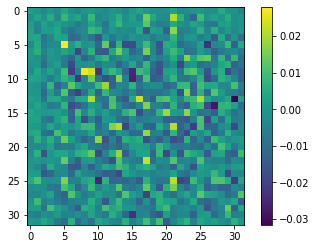

In [ ]:
plt.imshow(generated_image[0,:,:,0])
plt.colorbar()
plt.show()

#### anlysis 🇰
noise를 넣어 generator를 생성하였을 때 32 by 32 3channel이 생성됨을 확인할 수 있다.

## work (4) : design of discriminator

In [ ]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64*3, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128*3, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 16, 16, 192)       14592     
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 16, 16, 192)       0         
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 192)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 384)         1843584   
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 8, 8, 384)         0         
                                                                 
 dropout_5 (Dropout)         (None, 8, 8, 384)         0         
                                                                 
 flatten_2 (Flatten)         (None, 24576)            

In [ ]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.0001678]], dtype=float32)>

## work(5) : loss function

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cross_entropy

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

## work(6) : optimizer

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
## noise 

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## work(7) : config of training procedures

In [ ]:
from google.colab import drive
drive.mount('/content/mnt')

Mounted at /content/mnt


In [ ]:
save_path = '/content/mnt/MyDrive/Aiffel_LMS/EXP13_dcgan/fashion'
gen_folder = '/generated_samples'
check_folder = '/training_checkpoints'
history_folder = '/training_history'

In [ ]:
# with decorator


@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [ ]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')

    plt.savefig( save_path + '/generated_sample/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(epoch, it))

    plt.show()

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  

                                                     

    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig( save_path+ '/training_history/train_history_{:04d}.png'
                    .format(epoch))
    plt.show()

In [ ]:
checkpoint_dir = save_path + check_folder

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## work(8) : model training






In [ ]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[]

In [ ]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

ValueError: ignored

## limits

컬러 이미지에서 GAN이 형성되고 어떤 real과 fake이미지에 대한 accuracy를 측정해보려 하였다. 하지만 그레이 스케일이 아닌 컬러 스케일의 이미지 데이터에 대해서 discriminator의 input layer에서 문제가 발생하였다. 이 문제는 generated된 data 혹은 dataset data의 shape이 discriminator의 layer의 input shape과의 미스매치가 발생하였기 때문이다. 안타깝게도 구체적인 미스매치를 확인할 수 없어 프로젝트는 여기서 마무리하여야 했다. 

그레이 스케일에서는 LMS의 지도대로 흑백의 이미지들을 생성하는 결과를 얻을 수 있었다. 이 생선된 이미지에 대해서 real과 fake의 accuracy는 이상값인 0.5에 도달하지 못하였으며 GAN학습은 매우 어려운 부분이다. 얼마나 잘 fake 이미지를 만들어내느냐 얼마나 이미지를 잘 구분하느냐의 싸움은 보다 더 정밀한 관점에서 측정해보고 모델의 성능을 따로 시험해보아야 한다는 생각이 들었다.


